In [1]:
# torch.cuda.empty_cache()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import boto3
import io
import os

# new libraries
from models_package.models import Teacher, Student, CustomResNet18
from torchvision import datasets, transforms, models
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss, DD_loss, AD_loss, RKDDistanceLoss, RKDAngleLoss

In [7]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),  # Updated line
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return metrics

def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [8]:
# Hyperparameters
learning_rate = 0.03873108840244667 # 0.096779
num_epochs = 100 # 200
num_workers = 2
batch_size = 32
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 30
gamma = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping


In [9]:
# Load IdenProf dataset
train_path = '/home/ubuntu/W210-Capstone/notebooks/idenprof/train'
test_path = '/home/ubuntu/W210-Capstone/notebooks/idenprof/test'
# trainloader, testloader  = load_prof(train_path, test_path, batch_size=batch_size)


In [10]:
# # cifar 100
trainloader, testloader = load_cifar100()

# # cifar 10
# trainloader, testloader = load_cifar10()

Files already downloaded and verified
Files already downloaded and verified


In [16]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = models.resnet50(pretrained=True)  # Keep ResNet50 as it is
teacher_model.eval()  # Set teacher model to evaluation mode
student_model = CustomResNet18()

In [17]:
# Ensure the final classification layer is added to the model
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 100)
student_model.fc = nn.Linear(student_model.output_size, 100)

# Optimizer and scheduler for the student model
optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# teacher_model.to(device)
# student_model.to(device)


In [11]:
# 
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [12]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "0"


100%|██████████████████████████████████████████████████████| 782/782 [03:56<00:00,  3.30it/s]


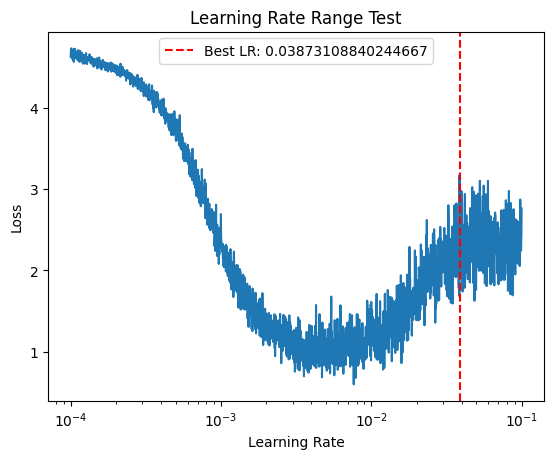

Best learning rate: 0.03873108840244667
0.03873108840244667


In [13]:
#### finding the optimal learning rate
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, lr_range=(1e-4, 1e-1), plot_loss=True):
    model.train()
    model.to(device)
    lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
    lr_iter = iter(lr_values)
    losses = []
    lrs = []
    
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            lr = next(lr_iter)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr  # Set new learning rate
            
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            lrs.append(lr)
    
    # Calculate the derivative of the loss
    loss_derivative = np.gradient(losses)
    
    # Find the learning rate corresponding to the minimum derivative (steepest decline)
    best_lr_index = np.argmin(loss_derivative)
    best_lr = lrs[best_lr_index]
    
    if plot_loss:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Learning Rate Range Test')
        plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
        plt.legend()
        plt.show()
    
    print(f'Best learning rate: {best_lr}')
    return best_lr

############# input ############## 
batch_size = 16  #to find the optimal learning rate
best_lr = train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, 
                        teacher_scheduler, device, num_epochs=3)  
print(best_lr)

In [18]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, patience=5):
    model.train()
    model.to(device)
    best_train_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  
        
        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            # checkpoint
            torch.save(model.state_dict(), f'teacher_model_weights_rkd_prof_checkpoint.pth')
            torch.save(model, f'teacher_model_rkd_prof_checkpoint.pth')

        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

        scheduler.step()

    print("Finished Training Teacher")


# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, patience=5):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    best_train_loss = float('inf')  
    patience_counter = 0 

    for epoch in range(num_epochs):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            # ce_loss = criterion(student_outputs, labels)
            # kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # from utils.loss_functions
            # loss = alpha * kd_loss + (1 - alpha) * ce_loss

            distance_loss = RKDDistanceLoss()(student_outputs, teacher_outputs)
            angle_loss = RKDAngleLoss()(student_outputs, teacher_outputs)
            loss = criterion(student_outputs, labels) + 0.1 * (distance_loss + angle_loss)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if i % 100 == 99:  
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  

        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            torch.save(student.state_dict(), f'student_model_weights_rkd_prof_checkpoint.pth')
            torch.save(student, f'student_model_rkd_prof_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step() 

    print("Finished Training Student")

In [19]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [20]:
# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation(student_model, teacher_model, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=num_epochs)


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.31it/s]

[1, 100] loss: 3.779


 26%|█████████████▊                                        | 200/782 [01:00<02:59,  3.25it/s]

[1, 200] loss: 2.707


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[1, 300] loss: 2.209


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.32it/s]

[1, 400] loss: 1.943


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[1, 500] loss: 1.845


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:55,  3.29it/s]

[1, 600] loss: 1.729


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:25,  3.23it/s]

[1, 700] loss: 1.648


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.30it/s]

[2, 100] loss: 1.398


 26%|█████████████▊                                        | 200/782 [01:00<02:56,  3.30it/s]

[2, 200] loss: 1.339


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.32it/s]

[2, 300] loss: 1.314


 51%|███████████████████████████▌                          | 400/782 [02:00<01:55,  3.30it/s]

[2, 400] loss: 1.290


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.29it/s]

[2, 500] loss: 1.256


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:54,  3.31it/s]

[2, 600] loss: 1.227


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:24,  3.31it/s]

[2, 700] loss: 1.150


 13%|██████▉                                               | 100/782 [00:30<03:25,  3.32it/s]

[3, 100] loss: 0.906


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.32it/s]

[3, 200] loss: 0.948


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[3, 300] loss: 0.949


 51%|███████████████████████████▌                          | 400/782 [02:00<01:55,  3.31it/s]

[3, 400] loss: 0.929


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[3, 500] loss: 0.952


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:54,  3.32it/s]

[3, 600] loss: 0.923


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:24,  3.30it/s]

[3, 700] loss: 0.971


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.31it/s]

[4, 100] loss: 0.685


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.31it/s]

[4, 200] loss: 0.699


 38%|████████████████████▋                                 | 300/782 [01:31<02:28,  3.24it/s]

[4, 300] loss: 0.705


 51%|███████████████████████████▌                          | 400/782 [02:02<01:57,  3.25it/s]

[4, 400] loss: 0.736


 64%|██████████████████████████████████▌                   | 500/782 [02:32<01:26,  3.26it/s]

[4, 500] loss: 0.745


 77%|█████████████████████████████████████████▍            | 600/782 [03:03<00:55,  3.30it/s]

[4, 600] loss: 0.736


 90%|████████████████████████████████████████████████▎     | 700/782 [03:33<00:24,  3.31it/s]

[4, 700] loss: 0.741


 13%|██████▉                                               | 100/782 [00:30<03:25,  3.31it/s]

[5, 100] loss: 0.535


 26%|█████████████▊                                        | 200/782 [01:00<02:56,  3.30it/s]

[5, 200] loss: 0.510


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[5, 300] loss: 0.541


 51%|███████████████████████████▌                          | 400/782 [02:00<01:55,  3.31it/s]

[5, 400] loss: 0.530


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[5, 500] loss: 0.552


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:55,  3.25it/s]

[5, 600] loss: 0.559


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:25,  3.26it/s]

[5, 700] loss: 0.625


 13%|██████▉                                               | 100/782 [00:30<03:29,  3.25it/s]

[6, 100] loss: 0.382


 26%|█████████████▊                                        | 200/782 [01:01<02:57,  3.29it/s]

[6, 200] loss: 0.377


 38%|████████████████████▋                                 | 300/782 [01:31<02:25,  3.30it/s]

[6, 300] loss: 0.386


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[6, 400] loss: 0.419


 64%|██████████████████████████████████▌                   | 500/782 [02:32<01:26,  3.26it/s]

[6, 500] loss: 0.415


 77%|█████████████████████████████████████████▍            | 600/782 [03:03<00:56,  3.24it/s]

[6, 600] loss: 0.468


 90%|████████████████████████████████████████████████▎     | 700/782 [03:33<00:25,  3.26it/s]

[6, 700] loss: 0.490


 13%|██████▉                                               | 100/782 [00:30<03:27,  3.29it/s]

[7, 100] loss: 0.292


 26%|█████████████▊                                        | 200/782 [01:01<02:58,  3.26it/s]

[7, 200] loss: 0.292


 38%|████████████████████▋                                 | 300/782 [01:31<02:26,  3.29it/s]

[7, 300] loss: 0.291


 51%|███████████████████████████▌                          | 400/782 [02:02<01:55,  3.31it/s]

[7, 400] loss: 0.335


 64%|██████████████████████████████████▌                   | 500/782 [02:32<01:25,  3.31it/s]

[7, 500] loss: 0.337


 77%|█████████████████████████████████████████▍            | 600/782 [03:03<00:55,  3.29it/s]

[7, 600] loss: 0.330


 90%|████████████████████████████████████████████████▎     | 700/782 [03:33<00:24,  3.31it/s]

[7, 700] loss: 0.372


 13%|██████▉                                               | 100/782 [00:30<03:25,  3.32it/s]

[8, 100] loss: 0.266


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.32it/s]

[8, 200] loss: 0.222


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[8, 300] loss: 0.209


 51%|███████████████████████████▌                          | 400/782 [02:00<01:55,  3.31it/s]

[8, 400] loss: 0.229


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:26,  3.27it/s]

[8, 500] loss: 0.277


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:54,  3.31it/s]

[8, 600] loss: 0.280


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:25,  3.25it/s]

[8, 700] loss: 0.278


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.30it/s]

[9, 100] loss: 0.177


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.31it/s]

[9, 200] loss: 0.163


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[9, 300] loss: 0.143


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[9, 400] loss: 0.177


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[9, 500] loss: 0.192


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:55,  3.31it/s]

[9, 600] loss: 0.196


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:24,  3.32it/s]

[9, 700] loss: 0.216


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.30it/s]

[10, 100] loss: 0.144


 26%|█████████████▊                                        | 200/782 [01:00<02:56,  3.31it/s]

[10, 200] loss: 0.108


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[10, 300] loss: 0.121


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[10, 400] loss: 0.138


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:26,  3.26it/s]

[10, 500] loss: 0.156


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:54,  3.31it/s]

[10, 600] loss: 0.147


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:25,  3.27it/s]

[10, 700] loss: 0.180


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.30it/s]

[11, 100] loss: 0.107


 26%|█████████████▊                                        | 200/782 [01:00<02:57,  3.28it/s]

[11, 200] loss: 0.075


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[11, 300] loss: 0.086


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[11, 400] loss: 0.084


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[11, 500] loss: 0.093


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:54,  3.31it/s]

[11, 600] loss: 0.118


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:24,  3.31it/s]

[11, 700] loss: 0.131


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.30it/s]

[12, 100] loss: 0.101


 26%|█████████████▊                                        | 200/782 [01:00<02:56,  3.30it/s]

[12, 200] loss: 0.074


 38%|████████████████████▋                                 | 300/782 [01:30<02:26,  3.30it/s]

[12, 300] loss: 0.075


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[12, 400] loss: 0.078


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[12, 500] loss: 0.086


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:54,  3.31it/s]

[12, 600] loss: 0.083


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:24,  3.31it/s]

[12, 700] loss: 0.108


 13%|██████▉                                               | 100/782 [00:30<03:25,  3.31it/s]

[13, 100] loss: 0.074


 26%|█████████████▊                                        | 200/782 [01:00<02:58,  3.26it/s]

[13, 200] loss: 0.043


 38%|████████████████████▋                                 | 300/782 [01:31<02:26,  3.29it/s]

[13, 300] loss: 0.055


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[13, 400] loss: 0.075


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[13, 500] loss: 0.065


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:56,  3.25it/s]

[13, 600] loss: 0.089


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:25,  3.26it/s]

[13, 700] loss: 0.071


 13%|██████▉                                               | 100/782 [00:30<03:29,  3.25it/s]

[14, 100] loss: 0.058


 26%|█████████████▊                                        | 200/782 [01:01<02:59,  3.25it/s]

[14, 200] loss: 0.057


 38%|████████████████████▋                                 | 300/782 [01:32<02:25,  3.31it/s]

[14, 300] loss: 0.054


 51%|███████████████████████████▌                          | 400/782 [02:02<01:55,  3.31it/s]

[14, 400] loss: 0.054


 64%|██████████████████████████████████▌                   | 500/782 [02:32<01:25,  3.31it/s]

[14, 500] loss: 0.062


 77%|█████████████████████████████████████████▍            | 600/782 [03:02<00:55,  3.31it/s]

[14, 600] loss: 0.054


 90%|████████████████████████████████████████████████▎     | 700/782 [03:33<00:24,  3.30it/s]

[14, 700] loss: 0.059


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.30it/s]

[15, 100] loss: 0.038


 26%|█████████████▊                                        | 200/782 [01:00<02:56,  3.30it/s]

[15, 200] loss: 0.034


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[15, 300] loss: 0.033


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[15, 400] loss: 0.034


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:26,  3.27it/s]

[15, 500] loss: 0.033


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:54,  3.31it/s]

[15, 600] loss: 0.041


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:24,  3.30it/s]

[15, 700] loss: 0.043


 13%|██████▉                                               | 100/782 [00:30<03:28,  3.27it/s]

[16, 100] loss: 0.025


 26%|█████████████▊                                        | 200/782 [01:01<02:59,  3.24it/s]

[16, 200] loss: 0.020


 38%|████████████████████▋                                 | 300/782 [01:32<02:28,  3.25it/s]

[16, 300] loss: 0.019


 51%|███████████████████████████▌                          | 400/782 [02:02<01:58,  3.23it/s]

[16, 400] loss: 0.016


 64%|██████████████████████████████████▌                   | 500/782 [02:33<01:26,  3.25it/s]

[16, 500] loss: 0.018


 77%|█████████████████████████████████████████▍            | 600/782 [03:04<00:55,  3.30it/s]

[16, 600] loss: 0.016


 90%|████████████████████████████████████████████████▎     | 700/782 [03:34<00:24,  3.29it/s]

[16, 700] loss: 0.019


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.31it/s]

[17, 100] loss: 0.012


 26%|█████████████▊                                        | 200/782 [01:00<02:56,  3.30it/s]

[17, 200] loss: 0.013


 38%|████████████████████▋                                 | 300/782 [01:30<02:27,  3.27it/s]

[17, 300] loss: 0.006


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[17, 400] loss: 0.010


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.29it/s]

[17, 500] loss: 0.012


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:55,  3.30it/s]

[17, 600] loss: 0.010


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:24,  3.31it/s]

[17, 700] loss: 0.013


 13%|██████▉                                               | 100/782 [00:30<03:25,  3.31it/s]

[18, 100] loss: 0.007


 26%|█████████████▊                                        | 200/782 [01:00<02:56,  3.30it/s]

[18, 200] loss: 0.006


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[18, 300] loss: 0.005


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.30it/s]

[18, 400] loss: 0.005


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.30it/s]

[18, 500] loss: 0.006


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:54,  3.31it/s]

[18, 600] loss: 0.010


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:24,  3.30it/s]

[18, 700] loss: 0.008


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.31it/s]

[19, 100] loss: 0.003


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.31it/s]

[19, 200] loss: 0.005


 38%|████████████████████▋                                 | 300/782 [01:31<02:27,  3.26it/s]

[19, 300] loss: 0.003


 51%|███████████████████████████▌                          | 400/782 [02:01<01:57,  3.25it/s]

[19, 400] loss: 0.003


 64%|██████████████████████████████████▌                   | 500/782 [02:32<01:25,  3.31it/s]

[19, 500] loss: 0.004


 77%|█████████████████████████████████████████▍            | 600/782 [03:02<00:55,  3.29it/s]

[19, 600] loss: 0.004


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:24,  3.30it/s]

[19, 700] loss: 0.004


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.30it/s]

[20, 100] loss: 0.002


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.31it/s]

[20, 200] loss: 0.002


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.30it/s]

[20, 300] loss: 0.003


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.30it/s]

[20, 400] loss: 0.004


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.30it/s]

[20, 500] loss: 0.003


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:55,  3.30it/s]

[20, 600] loss: 0.004


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:24,  3.31it/s]

[20, 700] loss: 0.005


 13%|██████▉                                               | 100/782 [00:30<03:28,  3.26it/s]

[21, 100] loss: 0.003


 26%|█████████████▊                                        | 200/782 [01:01<02:56,  3.29it/s]

[21, 200] loss: 0.004


 38%|████████████████████▋                                 | 300/782 [01:31<02:25,  3.31it/s]

[21, 300] loss: 0.003


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[21, 400] loss: 0.005


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.30it/s]

[21, 500] loss: 0.004


 77%|█████████████████████████████████████████▍            | 600/782 [03:02<00:55,  3.31it/s]

[21, 600] loss: 0.002


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:24,  3.31it/s]

[21, 700] loss: 0.005


 13%|██████▉                                               | 100/782 [00:30<03:29,  3.25it/s]

[22, 100] loss: 0.008


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.31it/s]

[22, 200] loss: 0.004


 38%|████████████████████▋                                 | 300/782 [01:31<02:25,  3.31it/s]

[22, 300] loss: 0.003


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[22, 400] loss: 0.006


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.30it/s]

[22, 500] loss: 0.005


 77%|█████████████████████████████████████████▍            | 600/782 [03:02<00:55,  3.31it/s]

[22, 600] loss: 0.004


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:24,  3.30it/s]

[22, 700] loss: 0.006


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.30it/s]

[23, 100] loss: 0.001


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.31it/s]

[23, 200] loss: 0.002


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[23, 300] loss: 0.002


 51%|███████████████████████████▌                          | 400/782 [02:01<01:56,  3.29it/s]

[23, 400] loss: 0.003


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[23, 500] loss: 0.001


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:55,  3.30it/s]

[23, 600] loss: 0.002


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:24,  3.31it/s]

[23, 700] loss: 0.003


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.31it/s]

[24, 100] loss: 0.003


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.31it/s]

[24, 200] loss: 0.003


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[24, 300] loss: 0.002


 51%|███████████████████████████▌                          | 400/782 [02:01<01:57,  3.25it/s]

[24, 400] loss: 0.002


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[24, 500] loss: 0.002


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:54,  3.31it/s]

[24, 600] loss: 0.001


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:24,  3.30it/s]

[24, 700] loss: 0.004


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.31it/s]

[25, 100] loss: 0.004


 26%|█████████████▊                                        | 200/782 [01:00<02:56,  3.29it/s]

[25, 200] loss: 0.006


 38%|████████████████████▋                                 | 300/782 [01:31<02:26,  3.30it/s]

[25, 300] loss: 0.003


 51%|███████████████████████████▌                          | 400/782 [02:01<01:56,  3.27it/s]

[25, 400] loss: 0.002


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[25, 500] loss: 0.002


 77%|█████████████████████████████████████████▍            | 600/782 [03:02<00:55,  3.30it/s]

[25, 600] loss: 0.002


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:24,  3.31it/s]

[25, 700] loss: 0.001


 13%|██████▉                                               | 100/782 [00:30<03:25,  3.31it/s]

[26, 100] loss: 0.001


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.31it/s]

[26, 200] loss: 0.001


 38%|████████████████████▋                                 | 300/782 [01:30<02:26,  3.29it/s]

[26, 300] loss: 0.002


 51%|███████████████████████████▌                          | 400/782 [02:01<01:57,  3.26it/s]

[26, 400] loss: 0.002


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[26, 500] loss: 0.001


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:55,  3.31it/s]

[26, 600] loss: 0.001


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:24,  3.31it/s]

[26, 700] loss: 0.001


 13%|██████▉                                               | 100/782 [00:30<03:29,  3.25it/s]

[27, 100] loss: 0.001


 26%|█████████████▊                                        | 200/782 [01:00<02:57,  3.28it/s]

[27, 200] loss: 0.001


 38%|████████████████████▋                                 | 300/782 [01:30<02:26,  3.30it/s]

[27, 300] loss: 0.001


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[27, 400] loss: 0.000


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.30it/s]

[27, 500] loss: 0.001


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:55,  3.29it/s]

[27, 600] loss: 0.001


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:24,  3.31it/s]

[27, 700] loss: 0.002


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.31it/s]

[28, 100] loss: 0.001


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.31it/s]

[28, 200] loss: 0.000


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.30it/s]

[28, 300] loss: 0.001


 51%|███████████████████████████▌                          | 400/782 [02:00<01:55,  3.31it/s]

[28, 400] loss: 0.001


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.30it/s]

[28, 500] loss: 0.001


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:55,  3.30it/s]

[28, 600] loss: 0.001


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:24,  3.31it/s]

[28, 700] loss: 0.001


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.30it/s]

[29, 100] loss: 0.001


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.31it/s]

[29, 200] loss: 0.000


 38%|████████████████████▋                                 | 300/782 [01:30<02:26,  3.30it/s]

[29, 300] loss: 0.001


 51%|███████████████████████████▌                          | 400/782 [02:01<01:56,  3.27it/s]

[29, 400] loss: 0.001


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.30it/s]

[29, 500] loss: 0.001


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:55,  3.30it/s]

[29, 600] loss: 0.001


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:24,  3.30it/s]

[29, 700] loss: 0.000


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.31it/s]

[30, 100] loss: 0.001


 26%|█████████████▊                                        | 200/782 [01:00<02:57,  3.27it/s]

[30, 200] loss: 0.000


 38%|████████████████████▋                                 | 300/782 [01:30<02:26,  3.28it/s]

[30, 300] loss: 0.001


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[30, 400] loss: 0.001


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[30, 500] loss: 0.001


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:55,  3.29it/s]

[30, 600] loss: 0.000


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:25,  3.24it/s]

[30, 700] loss: 0.000


 13%|██████▉                                               | 100/782 [00:30<03:31,  3.22it/s]

[31, 100] loss: 0.001


 26%|█████████████▊                                        | 200/782 [01:01<02:57,  3.28it/s]

[31, 200] loss: 0.001


 38%|████████████████████▋                                 | 300/782 [01:31<02:25,  3.31it/s]

[31, 300] loss: 0.001


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[31, 400] loss: 0.000


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.32it/s]

[31, 500] loss: 0.000


 77%|█████████████████████████████████████████▍            | 600/782 [03:02<00:54,  3.31it/s]

[31, 600] loss: 0.001


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:24,  3.28it/s]

[31, 700] loss: 0.000


 13%|██████▉                                               | 100/782 [00:30<03:29,  3.26it/s]

[32, 100] loss: 0.001


 26%|█████████████▊                                        | 200/782 [01:00<02:56,  3.31it/s]

[32, 200] loss: 0.001


 38%|████████████████████▋                                 | 300/782 [01:31<02:25,  3.31it/s]

[32, 300] loss: 0.000


 51%|███████████████████████████▌                          | 400/782 [02:01<01:56,  3.29it/s]

[32, 400] loss: 0.000


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[32, 500] loss: 0.000


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:55,  3.30it/s]

[32, 600] loss: 0.000


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:25,  3.26it/s]

[32, 700] loss: 0.000


 13%|██████▉                                               | 100/782 [00:30<03:29,  3.25it/s]

[33, 100] loss: 0.000


 26%|█████████████▊                                        | 200/782 [01:01<02:57,  3.29it/s]

[33, 200] loss: 0.000


 38%|████████████████████▋                                 | 300/782 [01:31<02:27,  3.26it/s]

[33, 300] loss: 0.000


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[33, 400] loss: 0.000


 64%|██████████████████████████████████▌                   | 500/782 [02:32<01:25,  3.30it/s]

[33, 500] loss: 0.000


 77%|█████████████████████████████████████████▍            | 600/782 [03:02<00:56,  3.25it/s]

[33, 600] loss: 0.001


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:24,  3.31it/s]

[33, 700] loss: 0.001


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.31it/s]

[34, 100] loss: 0.000


 26%|█████████████▊                                        | 200/782 [01:00<02:58,  3.27it/s]

[34, 200] loss: 0.000


 38%|████████████████████▋                                 | 300/782 [01:31<02:25,  3.31it/s]

[34, 300] loss: 0.001


 51%|███████████████████████████▌                          | 400/782 [02:01<01:56,  3.28it/s]

[34, 400] loss: 0.000


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:26,  3.27it/s]

[34, 500] loss: 0.001


 77%|█████████████████████████████████████████▍            | 600/782 [03:02<00:55,  3.28it/s]

[34, 600] loss: 0.000


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:24,  3.29it/s]

[34, 700] loss: 0.001


 13%|██████▉                                               | 100/782 [00:30<03:29,  3.25it/s]

[35, 100] loss: 0.001


 26%|█████████████▊                                        | 200/782 [01:01<02:59,  3.25it/s]

[35, 200] loss: 0.000


 38%|████████████████████▋                                 | 300/782 [01:32<02:27,  3.27it/s]

[35, 300] loss: 0.000


 51%|███████████████████████████▌                          | 400/782 [02:02<01:58,  3.24it/s]

[35, 400] loss: 0.001


 64%|██████████████████████████████████▌                   | 500/782 [02:32<01:25,  3.30it/s]

[35, 500] loss: 0.000


 77%|█████████████████████████████████████████▍            | 600/782 [03:03<00:54,  3.31it/s]

[35, 600] loss: 0.000


 90%|████████████████████████████████████████████████▎     | 700/782 [03:33<00:24,  3.31it/s]

[35, 700] loss: 0.000


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.30it/s]

[36, 100] loss: 0.000


 26%|█████████████▊                                        | 200/782 [01:00<02:56,  3.30it/s]

[36, 200] loss: 0.000


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[36, 300] loss: 0.000


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.30it/s]

[36, 400] loss: 0.000


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[36, 500] loss: 0.000


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:55,  3.30it/s]

[36, 600] loss: 0.000


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:24,  3.31it/s]

[36, 700] loss: 0.000


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.31it/s]

[37, 100] loss: 0.000


 26%|█████████████▊                                        | 200/782 [01:00<02:56,  3.31it/s]

[37, 200] loss: 0.000


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[37, 300] loss: 0.000


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.30it/s]

[37, 400] loss: 0.000


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.29it/s]

[37, 500] loss: 0.000


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:55,  3.30it/s]

[37, 600] loss: 0.001


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:24,  3.31it/s]

[37, 700] loss: 0.001


 13%|██████▉                                               | 100/782 [00:30<03:25,  3.31it/s]

[38, 100] loss: 0.000


 26%|█████████████▊                                        | 200/782 [01:00<02:57,  3.28it/s]

[38, 200] loss: 0.000


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[38, 300] loss: 0.000


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[38, 400] loss: 0.000


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[38, 500] loss: 0.001


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:55,  3.30it/s]

[38, 600] loss: 0.001


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:24,  3.30it/s]

[38, 700] loss: 0.000


 13%|██████▉                                               | 100/782 [00:30<03:25,  3.31it/s]

[39, 100] loss: 0.001


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.31it/s]

[39, 200] loss: 0.000


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[39, 300] loss: 0.000


 51%|███████████████████████████▌                          | 400/782 [02:01<01:56,  3.29it/s]

[39, 400] loss: 0.000


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:27,  3.23it/s]

[39, 500] loss: 0.000


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:54,  3.31it/s]

[39, 600] loss: 0.001


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:25,  3.26it/s]

[39, 700] loss: 0.000


 13%|██████▉                                               | 100/782 [00:30<03:25,  3.31it/s]

[40, 100] loss: 0.000


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.31it/s]

[40, 200] loss: 0.000


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[40, 300] loss: 0.000


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[40, 400] loss: 0.000


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[40, 500] loss: 0.001


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:55,  3.30it/s]

[40, 600] loss: 0.001


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:24,  3.30it/s]

[40, 700] loss: 0.001


 13%|██████▉                                               | 100/782 [00:30<03:25,  3.31it/s]

[41, 100] loss: 0.000


 26%|█████████████▊                                        | 200/782 [01:00<02:56,  3.30it/s]

[41, 200] loss: 0.000


 38%|████████████████████▋                                 | 300/782 [01:31<02:28,  3.25it/s]

[41, 300] loss: 0.001


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.30it/s]

[41, 400] loss: 0.000


 64%|██████████████████████████████████▌                   | 500/782 [02:32<01:26,  3.26it/s]

[41, 500] loss: 0.000


 77%|█████████████████████████████████████████▍            | 600/782 [03:02<00:55,  3.31it/s]

[41, 600] loss: 0.000


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:24,  3.31it/s]

[41, 700] loss: 0.000


 13%|██████▉                                               | 100/782 [00:30<03:25,  3.31it/s]

[42, 100] loss: 0.000


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.31it/s]

[42, 200] loss: 0.001


 38%|████████████████████▋                                 | 300/782 [01:30<02:26,  3.29it/s]

[42, 300] loss: 0.000


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[42, 400] loss: 0.001


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[42, 500] loss: 0.000


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:54,  3.31it/s]

[42, 600] loss: 0.000


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:24,  3.31it/s]

[42, 700] loss: 0.000


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.30it/s]

[43, 100] loss: 0.001


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.31it/s]

[43, 200] loss: 0.000


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[43, 300] loss: 0.001


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.29it/s]

[43, 400] loss: 0.000


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[43, 500] loss: 0.000


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:54,  3.32it/s]

[43, 600] loss: 0.000


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:24,  3.31it/s]

[43, 700] loss: 0.000


 13%|██████▉                                               | 100/782 [00:30<03:27,  3.29it/s]

[44, 100] loss: 0.001


 26%|█████████████▊                                        | 200/782 [01:00<02:59,  3.25it/s]

[44, 200] loss: 0.000


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[44, 300] loss: 0.000


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[44, 400] loss: 0.001


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[44, 500] loss: 0.000


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:54,  3.32it/s]

[44, 600] loss: 0.000


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:24,  3.31it/s]

[44, 700] loss: 0.001


 13%|██████▉                                               | 100/782 [00:30<03:26,  3.30it/s]

[45, 100] loss: 0.000


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.31it/s]

[45, 200] loss: 0.000


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[45, 300] loss: 0.000


 51%|███████████████████████████▌                          | 400/782 [02:01<01:55,  3.31it/s]

[45, 400] loss: 0.001


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.30it/s]

[45, 500] loss: 0.000


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:55,  3.26it/s]

[45, 600] loss: 0.001


 90%|████████████████████████████████████████████████▎     | 700/782 [03:32<00:25,  3.27it/s]

[45, 700] loss: 0.000


 13%|██████▉                                               | 100/782 [00:30<03:25,  3.31it/s]

[46, 100] loss: 0.001


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.31it/s]

[46, 200] loss: 0.001


 38%|████████████████████▋                                 | 300/782 [01:31<02:28,  3.25it/s]

[46, 300] loss: 0.000


 51%|███████████████████████████▌                          | 400/782 [02:01<01:56,  3.29it/s]

[46, 400] loss: 0.000


 64%|██████████████████████████████████▌                   | 500/782 [02:32<01:25,  3.31it/s]

[46, 500] loss: 0.000


 77%|█████████████████████████████████████████▍            | 600/782 [03:02<00:55,  3.25it/s]

[46, 600] loss: 0.000


 90%|████████████████████████████████████████████████▎     | 700/782 [03:33<00:24,  3.30it/s]

[46, 700] loss: 0.001


 13%|██████▉                                               | 100/782 [00:30<03:25,  3.31it/s]

[47, 100] loss: 0.000


 26%|█████████████▊                                        | 200/782 [01:00<02:55,  3.31it/s]

[47, 200] loss: 0.001


 38%|████████████████████▋                                 | 300/782 [01:30<02:25,  3.31it/s]

[47, 300] loss: 0.000


 51%|███████████████████████████▌                          | 400/782 [02:00<01:55,  3.31it/s]

[47, 400] loss: 0.001


 64%|██████████████████████████████████▌                   | 500/782 [02:31<01:25,  3.31it/s]

[47, 500] loss: 0.001


 77%|█████████████████████████████████████████▍            | 600/782 [03:01<00:56,  3.25it/s]

[47, 600] loss: 0.000


 90%|████████████████████████████████████████████████▎     | 700/782 [03:31<00:25,  3.27it/s]

[47, 700] loss: 0.000


100%|██████████████████████████████████████████████████████| 782/782 [03:56<00:00,  3.31it/s]


Early stopping
Finished Training Teacher


 13%|██████▉                                               | 100/782 [00:22<02:28,  4.59it/s]

[1, 100] loss: 10.884


 26%|█████████████▊                                        | 200/782 [00:44<02:06,  4.59it/s]

[1, 200] loss: 10.213


 38%|████████████████████▋                                 | 300/782 [01:06<01:44,  4.60it/s]

[1, 300] loss: 9.937


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.57it/s]

[1, 400] loss: 9.799


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:03,  4.47it/s]

[1, 500] loss: 9.628


 77%|█████████████████████████████████████████▍            | 600/782 [02:12<00:39,  4.58it/s]

[1, 600] loss: 9.515


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:17,  4.58it/s]

[1, 700] loss: 9.337


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.60it/s]

[2, 100] loss: 8.895


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.59it/s]

[2, 200] loss: 8.664


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.59it/s]

[2, 300] loss: 8.465


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.60it/s]

[2, 400] loss: 8.245


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.59it/s]

[2, 500] loss: 8.009


 77%|█████████████████████████████████████████▍            | 600/782 [02:10<00:39,  4.58it/s]

[2, 600] loss: 7.843


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.59it/s]

[2, 700] loss: 7.634


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[3, 100] loss: 7.254


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.57it/s]

[3, 200] loss: 7.170


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.59it/s]

[3, 300] loss: 7.047


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.57it/s]

[3, 400] loss: 6.913


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[3, 500] loss: 6.880


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[3, 600] loss: 6.686


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.59it/s]

[3, 700] loss: 6.647


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[4, 100] loss: 6.206


 26%|█████████████▊                                        | 200/782 [00:43<02:08,  4.53it/s]

[4, 200] loss: 6.220


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.57it/s]

[4, 300] loss: 6.140


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.57it/s]

[4, 400] loss: 6.047


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.57it/s]

[4, 500] loss: 5.992


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[4, 600] loss: 6.007


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.59it/s]

[4, 700] loss: 5.922


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.56it/s]

[5, 100] loss: 5.474


 26%|█████████████▊                                        | 200/782 [00:43<02:09,  4.48it/s]

[5, 200] loss: 5.446


 38%|████████████████████▋                                 | 300/782 [01:05<01:44,  4.59it/s]

[5, 300] loss: 5.400


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.56it/s]

[5, 400] loss: 5.462


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[5, 500] loss: 5.369


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[5, 600] loss: 5.397


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.56it/s]

[5, 700] loss: 5.382


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[6, 100] loss: 4.866


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.58it/s]

[6, 200] loss: 4.779


 38%|████████████████████▋                                 | 300/782 [01:05<01:44,  4.60it/s]

[6, 300] loss: 4.827


 51%|███████████████████████████▌                          | 400/782 [01:27<01:24,  4.54it/s]

[6, 400] loss: 4.877


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:03,  4.47it/s]

[6, 500] loss: 4.831


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[6, 600] loss: 4.836


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.59it/s]

[6, 700] loss: 4.837


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[7, 100] loss: 4.216


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.59it/s]

[7, 200] loss: 4.227


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.59it/s]

[7, 300] loss: 4.275


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.59it/s]

[7, 400] loss: 4.319


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:02,  4.52it/s]

[7, 500] loss: 4.271


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[7, 600] loss: 4.334


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.58it/s]

[7, 700] loss: 4.357


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.58it/s]

[8, 100] loss: 3.794


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.56it/s]

[8, 200] loss: 3.678


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[8, 300] loss: 3.712


 51%|███████████████████████████▌                          | 400/782 [01:27<01:24,  4.54it/s]

[8, 400] loss: 3.722


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:02,  4.53it/s]

[8, 500] loss: 3.753


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[8, 600] loss: 3.766


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.59it/s]

[8, 700] loss: 3.881


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[9, 100] loss: 3.331


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.59it/s]

[9, 200] loss: 3.218


 38%|████████████████████▋                                 | 300/782 [01:05<01:44,  4.60it/s]

[9, 300] loss: 3.260


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[9, 400] loss: 3.259


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.60it/s]

[9, 500] loss: 3.246


 77%|█████████████████████████████████████████▍            | 600/782 [02:10<00:39,  4.57it/s]

[9, 600] loss: 3.288


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.58it/s]

[9, 700] loss: 3.308


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.57it/s]

[10, 100] loss: 2.983


 26%|█████████████▊                                        | 200/782 [00:43<02:09,  4.49it/s]

[10, 200] loss: 2.896


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.57it/s]

[10, 300] loss: 2.905


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.59it/s]

[10, 400] loss: 2.882


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.59it/s]

[10, 500] loss: 2.885


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[10, 600] loss: 2.912


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.59it/s]

[10, 700] loss: 2.887


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[11, 100] loss: 2.647


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.57it/s]

[11, 200] loss: 2.628


 38%|████████████████████▋                                 | 300/782 [01:05<01:46,  4.52it/s]

[11, 300] loss: 2.611


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[11, 400] loss: 2.624


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.57it/s]

[11, 500] loss: 2.629


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:40,  4.46it/s]

[11, 600] loss: 2.658


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:18,  4.55it/s]

[11, 700] loss: 2.643


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[12, 100] loss: 2.425


 26%|█████████████▊                                        | 200/782 [00:43<02:09,  4.49it/s]

[12, 200] loss: 2.411


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[12, 300] loss: 2.415


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[12, 400] loss: 2.421


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.55it/s]

[12, 500] loss: 2.423


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[12, 600] loss: 2.431


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.56it/s]

[12, 700] loss: 2.453


 13%|██████▉                                               | 100/782 [00:22<02:29,  4.55it/s]

[13, 100] loss: 2.268


 26%|█████████████▊                                        | 200/782 [00:44<02:07,  4.58it/s]

[13, 200] loss: 2.249


 38%|████████████████████▋                                 | 300/782 [01:06<01:47,  4.47it/s]

[13, 300] loss: 2.269


 51%|███████████████████████████▌                          | 400/782 [01:28<01:25,  4.45it/s]

[13, 400] loss: 2.286


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:01,  4.57it/s]

[13, 500] loss: 2.285


 77%|█████████████████████████████████████████▍            | 600/782 [02:12<00:39,  4.59it/s]

[13, 600] loss: 2.276


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:18,  4.54it/s]

[13, 700] loss: 2.286


 13%|██████▉                                               | 100/782 [00:21<02:30,  4.53it/s]

[14, 100] loss: 2.117


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.57it/s]

[14, 200] loss: 2.141


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.57it/s]

[14, 300] loss: 2.122


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.57it/s]

[14, 400] loss: 2.139


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.59it/s]

[14, 500] loss: 2.147


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[14, 600] loss: 2.152


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:18,  4.55it/s]

[14, 700] loss: 2.180


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.56it/s]

[15, 100] loss: 2.018


 26%|█████████████▊                                        | 200/782 [00:43<02:08,  4.53it/s]

[15, 200] loss: 2.016


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.59it/s]

[15, 300] loss: 2.021


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.56it/s]

[15, 400] loss: 2.026


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.59it/s]

[15, 500] loss: 2.051


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[15, 600] loss: 2.040


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.57it/s]

[15, 700] loss: 2.047


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.60it/s]

[16, 100] loss: 1.928


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.59it/s]

[16, 200] loss: 1.934


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.59it/s]

[16, 300] loss: 1.943


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.59it/s]

[16, 400] loss: 1.944


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[16, 500] loss: 1.946


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:40,  4.47it/s]

[16, 600] loss: 1.959


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:18,  4.55it/s]

[16, 700] loss: 1.968


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.56it/s]

[17, 100] loss: 1.852


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.58it/s]

[17, 200] loss: 1.857


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.56it/s]

[17, 300] loss: 1.864


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[17, 400] loss: 1.874


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.60it/s]

[17, 500] loss: 1.866


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[17, 600] loss: 1.898


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:18,  4.46it/s]

[17, 700] loss: 1.902


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[18, 100] loss: 1.813


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.57it/s]

[18, 200] loss: 1.793


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[18, 300] loss: 1.820


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.59it/s]

[18, 400] loss: 1.816


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[18, 500] loss: 1.817


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:40,  4.53it/s]

[18, 600] loss: 1.832


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:18,  4.45it/s]

[18, 700] loss: 1.821


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[19, 100] loss: 1.755


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.58it/s]

[19, 200] loss: 1.750


 38%|████████████████████▋                                 | 300/782 [01:05<01:44,  4.59it/s]

[19, 300] loss: 1.768


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[19, 400] loss: 1.759


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.59it/s]

[19, 500] loss: 1.770


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[19, 600] loss: 1.771


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.56it/s]

[19, 700] loss: 1.799


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[20, 100] loss: 1.711


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.58it/s]

[20, 200] loss: 1.723


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[20, 300] loss: 1.723


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.57it/s]

[20, 400] loss: 1.718


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[20, 500] loss: 1.732


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.57it/s]

[20, 600] loss: 1.728


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.59it/s]

[20, 700] loss: 1.739


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.57it/s]

[21, 100] loss: 1.666


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.59it/s]

[21, 200] loss: 1.664


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.57it/s]

[21, 300] loss: 1.677


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[21, 400] loss: 1.690


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.60it/s]

[21, 500] loss: 1.680


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[21, 600] loss: 1.708


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.56it/s]

[21, 700] loss: 1.678


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[22, 100] loss: 1.634


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.59it/s]

[22, 200] loss: 1.655


 38%|████████████████████▋                                 | 300/782 [01:05<01:44,  4.60it/s]

[22, 300] loss: 1.649


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.57it/s]

[22, 400] loss: 1.651


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[22, 500] loss: 1.655


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[22, 600] loss: 1.668


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.58it/s]

[22, 700] loss: 1.658


 13%|██████▉                                               | 100/782 [00:21<02:30,  4.53it/s]

[23, 100] loss: 1.611


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.58it/s]

[23, 200] loss: 1.593


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[23, 300] loss: 1.622


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.57it/s]

[23, 400] loss: 1.612


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:02,  4.51it/s]

[23, 500] loss: 1.614


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[23, 600] loss: 1.630


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.56it/s]

[23, 700] loss: 1.624


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.56it/s]

[24, 100] loss: 1.575


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.58it/s]

[24, 200] loss: 1.578


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[24, 300] loss: 1.583


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.59it/s]

[24, 400] loss: 1.590


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.55it/s]

[24, 500] loss: 1.594


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[24, 600] loss: 1.602


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.58it/s]

[24, 700] loss: 1.606


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[25, 100] loss: 1.551


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.58it/s]

[25, 200] loss: 1.568


 38%|████████████████████▋                                 | 300/782 [01:05<01:44,  4.59it/s]

[25, 300] loss: 1.565


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[25, 400] loss: 1.576


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.57it/s]

[25, 500] loss: 1.569


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[25, 600] loss: 1.566


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.59it/s]

[25, 700] loss: 1.581


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[26, 100] loss: 1.536


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.56it/s]

[26, 200] loss: 1.541


 38%|████████████████████▋                                 | 300/782 [01:05<01:44,  4.60it/s]

[26, 300] loss: 1.553


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[26, 400] loss: 1.538


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[26, 500] loss: 1.546


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[26, 600] loss: 1.553


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.59it/s]

[26, 700] loss: 1.552


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[27, 100] loss: 1.522


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.57it/s]

[27, 200] loss: 1.533


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.59it/s]

[27, 300] loss: 1.512


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[27, 400] loss: 1.535


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.59it/s]

[27, 500] loss: 1.519


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[27, 600] loss: 1.536


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.56it/s]

[27, 700] loss: 1.511


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[28, 100] loss: 1.505


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.55it/s]

[28, 200] loss: 1.495


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.56it/s]

[28, 300] loss: 1.491


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.56it/s]

[28, 400] loss: 1.494


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[28, 500] loss: 1.496


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[28, 600] loss: 1.497


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.59it/s]

[28, 700] loss: 1.524


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[29, 100] loss: 1.488


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.60it/s]

[29, 200] loss: 1.478


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[29, 300] loss: 1.491


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.59it/s]

[29, 400] loss: 1.477


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.59it/s]

[29, 500] loss: 1.492


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[29, 600] loss: 1.495


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.59it/s]

[29, 700] loss: 1.498


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[30, 100] loss: 1.467


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.57it/s]

[30, 200] loss: 1.460


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.56it/s]

[30, 300] loss: 1.445


 51%|███████████████████████████▌                          | 400/782 [01:27<01:25,  4.48it/s]

[30, 400] loss: 1.469


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:03,  4.44it/s]

[30, 500] loss: 1.466


 77%|█████████████████████████████████████████▍            | 600/782 [02:12<00:40,  4.55it/s]

[30, 600] loss: 1.472


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:17,  4.59it/s]

[30, 700] loss: 1.480


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[31, 100] loss: 1.383


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.56it/s]

[31, 200] loss: 1.355


 38%|████████████████████▋                                 | 300/782 [01:05<01:46,  4.54it/s]

[31, 300] loss: 1.355


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.59it/s]

[31, 400] loss: 1.328


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.57it/s]

[31, 500] loss: 1.343


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[31, 600] loss: 1.335


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.58it/s]

[31, 700] loss: 1.327


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[32, 100] loss: 1.291


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.57it/s]

[32, 200] loss: 1.292


 38%|████████████████████▋                                 | 300/782 [01:05<01:44,  4.59it/s]

[32, 300] loss: 1.290


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.59it/s]

[32, 400] loss: 1.291


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.57it/s]

[32, 500] loss: 1.292


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.56it/s]

[32, 600] loss: 1.293


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.59it/s]

[32, 700] loss: 1.284


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.56it/s]

[33, 100] loss: 1.279


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.59it/s]

[33, 200] loss: 1.265


 38%|████████████████████▋                                 | 300/782 [01:05<01:44,  4.59it/s]

[33, 300] loss: 1.265


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.59it/s]

[33, 400] loss: 1.272


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.57it/s]

[33, 500] loss: 1.264


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[33, 600] loss: 1.261


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.58it/s]

[33, 700] loss: 1.260


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[34, 100] loss: 1.243


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.58it/s]

[34, 200] loss: 1.243


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.57it/s]

[34, 300] loss: 1.231


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.59it/s]

[34, 400] loss: 1.249


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.56it/s]

[34, 500] loss: 1.255


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:40,  4.46it/s]

[34, 600] loss: 1.250


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:18,  4.45it/s]

[34, 700] loss: 1.254


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[35, 100] loss: 1.231


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.56it/s]

[35, 200] loss: 1.229


 38%|████████████████████▋                                 | 300/782 [01:05<01:44,  4.59it/s]

[35, 300] loss: 1.210


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.57it/s]

[35, 400] loss: 1.250


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[35, 500] loss: 1.217


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.56it/s]

[35, 600] loss: 1.239


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.56it/s]

[35, 700] loss: 1.243


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[36, 100] loss: 1.226


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.58it/s]

[36, 200] loss: 1.225


 38%|████████████████████▋                                 | 300/782 [01:05<01:44,  4.60it/s]

[36, 300] loss: 1.224


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.60it/s]

[36, 400] loss: 1.218


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.57it/s]

[36, 500] loss: 1.223


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:40,  4.46it/s]

[36, 600] loss: 1.215


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:18,  4.47it/s]

[36, 700] loss: 1.225


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.56it/s]

[37, 100] loss: 1.210


 26%|█████████████▊                                        | 200/782 [00:43<02:09,  4.49it/s]

[37, 200] loss: 1.210


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.55it/s]

[37, 300] loss: 1.222


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.59it/s]

[37, 400] loss: 1.212


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[37, 500] loss: 1.222


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.57it/s]

[37, 600] loss: 1.223


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.59it/s]

[37, 700] loss: 1.212


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[38, 100] loss: 1.226


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.58it/s]

[38, 200] loss: 1.205


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.59it/s]

[38, 300] loss: 1.200


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.57it/s]

[38, 400] loss: 1.208


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:03,  4.46it/s]

[38, 500] loss: 1.187


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:40,  4.55it/s]

[38, 600] loss: 1.199


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:18,  4.55it/s]

[38, 700] loss: 1.209


 13%|██████▉                                               | 100/782 [00:21<02:30,  4.52it/s]

[39, 100] loss: 1.209


 26%|█████████████▊                                        | 200/782 [00:43<02:08,  4.51it/s]

[39, 200] loss: 1.193


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.57it/s]

[39, 300] loss: 1.203


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.56it/s]

[39, 400] loss: 1.195


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:02,  4.54it/s]

[39, 500] loss: 1.202


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:40,  4.48it/s]

[39, 600] loss: 1.198


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.58it/s]

[39, 700] loss: 1.206


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.57it/s]

[40, 100] loss: 1.193


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.56it/s]

[40, 200] loss: 1.196


 38%|████████████████████▋                                 | 300/782 [01:05<01:47,  4.48it/s]

[40, 300] loss: 1.189


 51%|███████████████████████████▌                          | 400/782 [01:28<01:24,  4.50it/s]

[40, 400] loss: 1.205


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:02,  4.54it/s]

[40, 500] loss: 1.198


 77%|█████████████████████████████████████████▍            | 600/782 [02:12<00:39,  4.59it/s]

[40, 600] loss: 1.195


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:17,  4.58it/s]

[40, 700] loss: 1.195


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.57it/s]

[41, 100] loss: 1.197


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.58it/s]

[41, 200] loss: 1.196


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.59it/s]

[41, 300] loss: 1.190


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[41, 400] loss: 1.187


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.57it/s]

[41, 500] loss: 1.190


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[41, 600] loss: 1.200


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.58it/s]

[41, 700] loss: 1.191


 13%|██████▉                                               | 100/782 [00:22<02:32,  4.47it/s]

[42, 100] loss: 1.163


 26%|█████████████▊                                        | 200/782 [00:44<02:11,  4.44it/s]

[42, 200] loss: 1.184


 38%|████████████████████▋                                 | 300/782 [01:06<01:45,  4.56it/s]

[42, 300] loss: 1.193


 51%|███████████████████████████▌                          | 400/782 [01:28<01:23,  4.55it/s]

[42, 400] loss: 1.189


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:01,  4.58it/s]

[42, 500] loss: 1.185


 77%|█████████████████████████████████████████▍            | 600/782 [02:12<00:39,  4.58it/s]

[42, 600] loss: 1.180


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:17,  4.57it/s]

[42, 700] loss: 1.181


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.55it/s]

[43, 100] loss: 1.180


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.60it/s]

[43, 200] loss: 1.173


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[43, 300] loss: 1.193


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.57it/s]

[43, 400] loss: 1.191


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.57it/s]

[43, 500] loss: 1.179


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:40,  4.55it/s]

[43, 600] loss: 1.187


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.59it/s]

[43, 700] loss: 1.181


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[44, 100] loss: 1.188


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.58it/s]

[44, 200] loss: 1.175


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[44, 300] loss: 1.184


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.59it/s]

[44, 400] loss: 1.180


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.59it/s]

[44, 500] loss: 1.172


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[44, 600] loss: 1.176


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.59it/s]

[44, 700] loss: 1.183


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.57it/s]

[45, 100] loss: 1.170


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.59it/s]

[45, 200] loss: 1.178


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.57it/s]

[45, 300] loss: 1.183


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.57it/s]

[45, 400] loss: 1.173


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.57it/s]

[45, 500] loss: 1.177


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[45, 600] loss: 1.175


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.59it/s]

[45, 700] loss: 1.193


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[46, 100] loss: 1.163


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.57it/s]

[46, 200] loss: 1.163


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.55it/s]

[46, 300] loss: 1.171


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.59it/s]

[46, 400] loss: 1.181


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.59it/s]

[46, 500] loss: 1.169


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.57it/s]

[46, 600] loss: 1.173


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.58it/s]

[46, 700] loss: 1.152


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[47, 100] loss: 1.164


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.58it/s]

[47, 200] loss: 1.163


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.59it/s]

[47, 300] loss: 1.157


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[47, 400] loss: 1.154


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[47, 500] loss: 1.171


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[47, 600] loss: 1.166


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.59it/s]

[47, 700] loss: 1.161


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.57it/s]

[48, 100] loss: 1.158


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.58it/s]

[48, 200] loss: 1.160


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[48, 300] loss: 1.154


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.56it/s]

[48, 400] loss: 1.183


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.59it/s]

[48, 500] loss: 1.164


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[48, 600] loss: 1.156


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.56it/s]

[48, 700] loss: 1.155


 13%|██████▉                                               | 100/782 [00:21<02:30,  4.54it/s]

[49, 100] loss: 1.156


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.57it/s]

[49, 200] loss: 1.157


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[49, 300] loss: 1.168


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.57it/s]

[49, 400] loss: 1.163


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[49, 500] loss: 1.175


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[49, 600] loss: 1.164


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.58it/s]

[49, 700] loss: 1.168


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[50, 100] loss: 1.160


 26%|█████████████▊                                        | 200/782 [00:44<02:09,  4.49it/s]

[50, 200] loss: 1.167


 38%|████████████████████▋                                 | 300/782 [01:06<01:47,  4.48it/s]

[50, 300] loss: 1.158


 51%|███████████████████████████▌                          | 400/782 [01:29<01:25,  4.46it/s]

[50, 400] loss: 1.141


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:01,  4.56it/s]

[50, 500] loss: 1.155


 77%|█████████████████████████████████████████▍            | 600/782 [02:12<00:39,  4.59it/s]

[50, 600] loss: 1.164


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:18,  4.54it/s]

[50, 700] loss: 1.150


 13%|██████▉                                               | 100/782 [00:22<02:32,  4.47it/s]

[51, 100] loss: 1.158


 26%|█████████████▊                                        | 200/782 [00:44<02:10,  4.44it/s]

[51, 200] loss: 1.164


 38%|████████████████████▋                                 | 300/782 [01:06<01:45,  4.58it/s]

[51, 300] loss: 1.144


 51%|███████████████████████████▌                          | 400/782 [01:28<01:23,  4.59it/s]

[51, 400] loss: 1.148


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:01,  4.59it/s]

[51, 500] loss: 1.143


 77%|█████████████████████████████████████████▍            | 600/782 [02:12<00:40,  4.52it/s]

[51, 600] loss: 1.157


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:18,  4.55it/s]

[51, 700] loss: 1.167


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[52, 100] loss: 1.148


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.59it/s]

[52, 200] loss: 1.132


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.57it/s]

[52, 300] loss: 1.158


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[52, 400] loss: 1.144


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.59it/s]

[52, 500] loss: 1.158


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[52, 600] loss: 1.148


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.58it/s]

[52, 700] loss: 1.145


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.57it/s]

[53, 100] loss: 1.140


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.57it/s]

[53, 200] loss: 1.152


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.56it/s]

[53, 300] loss: 1.143


 51%|███████████████████████████▌                          | 400/782 [01:27<01:24,  4.53it/s]

[53, 400] loss: 1.164


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.56it/s]

[53, 500] loss: 1.140


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:40,  4.49it/s]

[53, 600] loss: 1.124


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.59it/s]

[53, 700] loss: 1.133


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.56it/s]

[54, 100] loss: 1.142


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.58it/s]

[54, 200] loss: 1.144


 38%|████████████████████▋                                 | 300/782 [01:05<01:44,  4.59it/s]

[54, 300] loss: 1.148


 51%|███████████████████████████▌                          | 400/782 [01:27<01:25,  4.49it/s]

[54, 400] loss: 1.147


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:02,  4.48it/s]

[54, 500] loss: 1.127


 77%|█████████████████████████████████████████▍            | 600/782 [02:12<00:40,  4.48it/s]

[54, 600] loss: 1.150


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:18,  4.55it/s]

[54, 700] loss: 1.149


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.56it/s]

[55, 100] loss: 1.145


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.57it/s]

[55, 200] loss: 1.133


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[55, 300] loss: 1.140


 51%|███████████████████████████▌                          | 400/782 [01:27<01:25,  4.47it/s]

[55, 400] loss: 1.139


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:02,  4.49it/s]

[55, 500] loss: 1.144


 77%|█████████████████████████████████████████▍            | 600/782 [02:12<00:40,  4.53it/s]

[55, 600] loss: 1.138


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:17,  4.57it/s]

[55, 700] loss: 1.146


 13%|██████▉                                               | 100/782 [00:22<02:33,  4.45it/s]

[56, 100] loss: 1.132


 26%|█████████████▊                                        | 200/782 [00:44<02:07,  4.57it/s]

[56, 200] loss: 1.136


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[56, 300] loss: 1.151


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[56, 400] loss: 1.139


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.55it/s]

[56, 500] loss: 1.136


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[56, 600] loss: 1.138


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.59it/s]

[56, 700] loss: 1.142


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[57, 100] loss: 1.136


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.58it/s]

[57, 200] loss: 1.158


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.57it/s]

[57, 300] loss: 1.140


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.56it/s]

[57, 400] loss: 1.123


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:02,  4.53it/s]

[57, 500] loss: 1.148


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[57, 600] loss: 1.133


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:18,  4.47it/s]

[57, 700] loss: 1.138


 13%|██████▉                                               | 100/782 [00:22<02:30,  4.55it/s]

[58, 100] loss: 1.137


 26%|█████████████▊                                        | 200/782 [00:44<02:08,  4.54it/s]

[58, 200] loss: 1.123


 38%|████████████████████▋                                 | 300/782 [01:06<01:45,  4.59it/s]

[58, 300] loss: 1.125


 51%|███████████████████████████▌                          | 400/782 [01:28<01:24,  4.54it/s]

[58, 400] loss: 1.123


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[58, 500] loss: 1.138


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[58, 600] loss: 1.126


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.58it/s]

[58, 700] loss: 1.125


 13%|██████▉                                               | 100/782 [00:22<02:32,  4.46it/s]

[59, 100] loss: 1.129


 26%|█████████████▊                                        | 200/782 [00:44<02:07,  4.56it/s]

[59, 200] loss: 1.134


 38%|████████████████████▋                                 | 300/782 [01:06<01:45,  4.59it/s]

[59, 300] loss: 1.129


 51%|███████████████████████████▌                          | 400/782 [01:28<01:23,  4.58it/s]

[59, 400] loss: 1.125


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:01,  4.57it/s]

[59, 500] loss: 1.127


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[59, 600] loss: 1.132


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.57it/s]

[59, 700] loss: 1.120


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.57it/s]

[60, 100] loss: 1.135


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.56it/s]

[60, 200] loss: 1.123


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[60, 300] loss: 1.115


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[60, 400] loss: 1.118


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.56it/s]

[60, 500] loss: 1.126


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[60, 600] loss: 1.131


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.59it/s]

[60, 700] loss: 1.128


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.57it/s]

[61, 100] loss: 1.109


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.58it/s]

[61, 200] loss: 1.115


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[61, 300] loss: 1.125


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.57it/s]

[61, 400] loss: 1.109


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:02,  4.54it/s]

[61, 500] loss: 1.103


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.57it/s]

[61, 600] loss: 1.104


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.59it/s]

[61, 700] loss: 1.102


 13%|██████▉                                               | 100/782 [00:21<02:31,  4.49it/s]

[62, 100] loss: 1.120


 26%|█████████████▊                                        | 200/782 [00:43<02:09,  4.50it/s]

[62, 200] loss: 1.107


 38%|████████████████████▋                                 | 300/782 [01:06<01:45,  4.56it/s]

[62, 300] loss: 1.112


 51%|███████████████████████████▌                          | 400/782 [01:28<01:23,  4.58it/s]

[62, 400] loss: 1.113


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[62, 500] loss: 1.102


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[62, 600] loss: 1.113


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.59it/s]

[62, 700] loss: 1.116


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[63, 100] loss: 1.118


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.58it/s]

[63, 200] loss: 1.117


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.56it/s]

[63, 300] loss: 1.104


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[63, 400] loss: 1.106


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.59it/s]

[63, 500] loss: 1.117


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:40,  4.48it/s]

[63, 600] loss: 1.103


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:18,  4.51it/s]

[63, 700] loss: 1.110


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[64, 100] loss: 1.107


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.57it/s]

[64, 200] loss: 1.106


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[64, 300] loss: 1.110


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.57it/s]

[64, 400] loss: 1.106


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.59it/s]

[64, 500] loss: 1.093


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.57it/s]

[64, 600] loss: 1.123


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:18,  4.55it/s]

[64, 700] loss: 1.102


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[65, 100] loss: 1.105


 26%|█████████████▊                                        | 200/782 [00:44<02:10,  4.45it/s]

[65, 200] loss: 1.113


 38%|████████████████████▋                                 | 300/782 [01:06<01:47,  4.46it/s]

[65, 300] loss: 1.105


 51%|███████████████████████████▌                          | 400/782 [01:28<01:23,  4.56it/s]

[65, 400] loss: 1.110


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:02,  4.55it/s]

[65, 500] loss: 1.096


 77%|█████████████████████████████████████████▍            | 600/782 [02:12<00:39,  4.59it/s]

[65, 600] loss: 1.118


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:17,  4.59it/s]

[65, 700] loss: 1.104


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[66, 100] loss: 1.106


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.59it/s]

[66, 200] loss: 1.111


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[66, 300] loss: 1.100


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.55it/s]

[66, 400] loss: 1.101


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.57it/s]

[66, 500] loss: 1.109


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.56it/s]

[66, 600] loss: 1.111


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:18,  4.52it/s]

[66, 700] loss: 1.107


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[67, 100] loss: 1.121


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.57it/s]

[67, 200] loss: 1.101


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.59it/s]

[67, 300] loss: 1.110


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.57it/s]

[67, 400] loss: 1.124


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.55it/s]

[67, 500] loss: 1.110


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[67, 600] loss: 1.120


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.57it/s]

[67, 700] loss: 1.100


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[68, 100] loss: 1.114


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.57it/s]

[68, 200] loss: 1.105


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.56it/s]

[68, 300] loss: 1.110


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.57it/s]

[68, 400] loss: 1.112


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[68, 500] loss: 1.107


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[68, 600] loss: 1.112


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.57it/s]

[68, 700] loss: 1.112


 13%|██████▉                                               | 100/782 [00:21<02:30,  4.52it/s]

[69, 100] loss: 1.105


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.58it/s]

[69, 200] loss: 1.098


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[69, 300] loss: 1.114


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[69, 400] loss: 1.104


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.60it/s]

[69, 500] loss: 1.105


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[69, 600] loss: 1.104


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.57it/s]

[69, 700] loss: 1.104


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.56it/s]

[70, 100] loss: 1.105


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.56it/s]

[70, 200] loss: 1.104


 38%|████████████████████▋                                 | 300/782 [01:05<01:46,  4.55it/s]

[70, 300] loss: 1.106


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[70, 400] loss: 1.104


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:02,  4.53it/s]

[70, 500] loss: 1.107


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.57it/s]

[70, 600] loss: 1.104


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.58it/s]

[70, 700] loss: 1.102


 13%|██████▉                                               | 100/782 [00:22<02:32,  4.48it/s]

[71, 100] loss: 1.106


 26%|█████████████▊                                        | 200/782 [00:44<02:07,  4.58it/s]

[71, 200] loss: 1.096


 38%|████████████████████▋                                 | 300/782 [01:06<01:45,  4.59it/s]

[71, 300] loss: 1.102


 51%|███████████████████████████▌                          | 400/782 [01:28<01:23,  4.58it/s]

[71, 400] loss: 1.117


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[71, 500] loss: 1.090


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[71, 600] loss: 1.100


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:18,  4.52it/s]

[71, 700] loss: 1.099


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.56it/s]

[72, 100] loss: 1.105


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.58it/s]

[72, 200] loss: 1.111


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[72, 300] loss: 1.102


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.55it/s]

[72, 400] loss: 1.092


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:02,  4.53it/s]

[72, 500] loss: 1.116


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[72, 600] loss: 1.107


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.57it/s]

[72, 700] loss: 1.100


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[73, 100] loss: 1.106


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.55it/s]

[73, 200] loss: 1.105


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[73, 300] loss: 1.097


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[73, 400] loss: 1.103


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.55it/s]

[73, 500] loss: 1.099


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.57it/s]

[73, 600] loss: 1.106


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.58it/s]

[73, 700] loss: 1.115


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[74, 100] loss: 1.105


 26%|█████████████▊                                        | 200/782 [00:43<02:10,  4.48it/s]

[74, 200] loss: 1.085


 38%|████████████████████▋                                 | 300/782 [01:06<01:47,  4.50it/s]

[74, 300] loss: 1.096


 51%|███████████████████████████▌                          | 400/782 [01:28<01:23,  4.57it/s]

[74, 400] loss: 1.115


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.56it/s]

[74, 500] loss: 1.103


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[74, 600] loss: 1.095


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.56it/s]

[74, 700] loss: 1.106


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.57it/s]

[75, 100] loss: 1.107


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.58it/s]

[75, 200] loss: 1.102


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[75, 300] loss: 1.101


 51%|███████████████████████████▌                          | 400/782 [01:27<01:25,  4.48it/s]

[75, 400] loss: 1.095


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:02,  4.52it/s]

[75, 500] loss: 1.090


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[75, 600] loss: 1.104


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.56it/s]

[75, 700] loss: 1.100


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.57it/s]

[76, 100] loss: 1.098


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.59it/s]

[76, 200] loss: 1.105


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.59it/s]

[76, 300] loss: 1.097


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[76, 400] loss: 1.109


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.59it/s]

[76, 500] loss: 1.096


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:40,  4.47it/s]

[76, 600] loss: 1.104


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:18,  4.44it/s]

[76, 700] loss: 1.096


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.57it/s]

[77, 100] loss: 1.099


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.58it/s]

[77, 200] loss: 1.104


 38%|████████████████████▋                                 | 300/782 [01:06<01:47,  4.46it/s]

[77, 300] loss: 1.097


 51%|███████████████████████████▌                          | 400/782 [01:28<01:25,  4.48it/s]

[77, 400] loss: 1.101


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:01,  4.59it/s]

[77, 500] loss: 1.107


 77%|█████████████████████████████████████████▍            | 600/782 [02:12<00:39,  4.57it/s]

[77, 600] loss: 1.104


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:17,  4.57it/s]

[77, 700] loss: 1.114


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[78, 100] loss: 1.108


 26%|█████████████▊                                        | 200/782 [00:43<02:08,  4.55it/s]

[78, 200] loss: 1.107


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.59it/s]

[78, 300] loss: 1.104


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[78, 400] loss: 1.092


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.59it/s]

[78, 500] loss: 1.098


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:40,  4.54it/s]

[78, 600] loss: 1.109


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.58it/s]

[78, 700] loss: 1.110


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[79, 100] loss: 1.103


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.58it/s]

[79, 200] loss: 1.088


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[79, 300] loss: 1.097


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[79, 400] loss: 1.108


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[79, 500] loss: 1.095


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:40,  4.46it/s]

[79, 600] loss: 1.099


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.58it/s]

[79, 700] loss: 1.100


 13%|██████▉                                               | 100/782 [00:22<02:33,  4.45it/s]

[80, 100] loss: 1.105


 26%|█████████████▊                                        | 200/782 [00:44<02:07,  4.56it/s]

[80, 200] loss: 1.096


 38%|████████████████████▋                                 | 300/782 [01:06<01:44,  4.59it/s]

[80, 300] loss: 1.095


 51%|███████████████████████████▌                          | 400/782 [01:28<01:23,  4.56it/s]

[80, 400] loss: 1.096


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:01,  4.59it/s]

[80, 500] loss: 1.100


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[80, 600] loss: 1.099


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.58it/s]

[80, 700] loss: 1.097


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[81, 100] loss: 1.093


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.58it/s]

[81, 200] loss: 1.100


 38%|████████████████████▋                                 | 300/782 [01:05<01:44,  4.59it/s]

[81, 300] loss: 1.096


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.59it/s]

[81, 400] loss: 1.095


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:02,  4.49it/s]

[81, 500] loss: 1.099


 77%|█████████████████████████████████████████▍            | 600/782 [02:12<00:41,  4.43it/s]

[81, 600] loss: 1.097


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:17,  4.57it/s]

[81, 700] loss: 1.113


 13%|██████▉                                               | 100/782 [00:21<02:30,  4.53it/s]

[82, 100] loss: 1.085


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.57it/s]

[82, 200] loss: 1.114


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.57it/s]

[82, 300] loss: 1.098


 51%|███████████████████████████▌                          | 400/782 [01:27<01:25,  4.47it/s]

[82, 400] loss: 1.092


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:03,  4.46it/s]

[82, 500] loss: 1.105


 77%|█████████████████████████████████████████▍            | 600/782 [02:12<00:40,  4.55it/s]

[82, 600] loss: 1.117


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:17,  4.57it/s]

[82, 700] loss: 1.109


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[83, 100] loss: 1.102


 26%|█████████████▊                                        | 200/782 [00:43<02:08,  4.54it/s]

[83, 200] loss: 1.098


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[83, 300] loss: 1.097


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.56it/s]

[83, 400] loss: 1.100


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.59it/s]

[83, 500] loss: 1.105


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:40,  4.54it/s]

[83, 600] loss: 1.103


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.59it/s]

[83, 700] loss: 1.101


 13%|██████▉                                               | 100/782 [00:22<02:32,  4.46it/s]

[84, 100] loss: 1.089


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.58it/s]

[84, 200] loss: 1.084


 38%|████████████████████▋                                 | 300/782 [01:06<01:47,  4.47it/s]

[84, 300] loss: 1.104


 51%|███████████████████████████▌                          | 400/782 [01:28<01:25,  4.46it/s]

[84, 400] loss: 1.093


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:03,  4.47it/s]

[84, 500] loss: 1.101


 77%|█████████████████████████████████████████▍            | 600/782 [02:13<00:39,  4.58it/s]

[84, 600] loss: 1.103


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:17,  4.58it/s]

[84, 700] loss: 1.100


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[85, 100] loss: 1.103


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.57it/s]

[85, 200] loss: 1.102


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[85, 300] loss: 1.103


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[85, 400] loss: 1.102


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.57it/s]

[85, 500] loss: 1.093


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:40,  4.55it/s]

[85, 600] loss: 1.089


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.58it/s]

[85, 700] loss: 1.105


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[86, 100] loss: 1.109


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.57it/s]

[86, 200] loss: 1.108


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[86, 300] loss: 1.097


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.57it/s]

[86, 400] loss: 1.102


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:02,  4.55it/s]

[86, 500] loss: 1.092


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[86, 600] loss: 1.096


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.58it/s]

[86, 700] loss: 1.094


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.55it/s]

[87, 100] loss: 1.108


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.60it/s]

[87, 200] loss: 1.088


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[87, 300] loss: 1.101


 51%|███████████████████████████▌                          | 400/782 [01:27<01:24,  4.53it/s]

[87, 400] loss: 1.103


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[87, 500] loss: 1.107


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.58it/s]

[87, 600] loss: 1.102


 90%|████████████████████████████████████████████████▎     | 700/782 [02:32<00:17,  4.59it/s]

[87, 700] loss: 1.090


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.59it/s]

[88, 100] loss: 1.090


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.58it/s]

[88, 200] loss: 1.097


 38%|████████████████████▋                                 | 300/782 [01:06<01:48,  4.45it/s]

[88, 300] loss: 1.100


 51%|███████████████████████████▌                          | 400/782 [01:28<01:23,  4.56it/s]

[88, 400] loss: 1.095


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:01,  4.56it/s]

[88, 500] loss: 1.104


 77%|█████████████████████████████████████████▍            | 600/782 [02:12<00:40,  4.47it/s]

[88, 600] loss: 1.095


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:18,  4.48it/s]

[88, 700] loss: 1.109


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.57it/s]

[89, 100] loss: 1.093


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.58it/s]

[89, 200] loss: 1.092


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.57it/s]

[89, 300] loss: 1.111


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.58it/s]

[89, 400] loss: 1.091


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.58it/s]

[89, 500] loss: 1.092


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.57it/s]

[89, 600] loss: 1.099


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.56it/s]

[89, 700] loss: 1.092


 13%|██████▉                                               | 100/782 [00:22<02:32,  4.46it/s]

[90, 100] loss: 1.107


 26%|█████████████▊                                        | 200/782 [00:44<02:09,  4.49it/s]

[90, 200] loss: 1.095


 38%|████████████████████▋                                 | 300/782 [01:06<01:45,  4.58it/s]

[90, 300] loss: 1.084


 51%|███████████████████████████▌                          | 400/782 [01:28<01:23,  4.58it/s]

[90, 400] loss: 1.086


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:01,  4.59it/s]

[90, 500] loss: 1.101


 77%|█████████████████████████████████████████▍            | 600/782 [02:12<00:40,  4.49it/s]

[90, 600] loss: 1.079


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:17,  4.57it/s]

[90, 700] loss: 1.086


 13%|██████▉                                               | 100/782 [00:21<02:28,  4.58it/s]

[91, 100] loss: 1.090


 26%|█████████████▊                                        | 200/782 [00:43<02:08,  4.53it/s]

[91, 200] loss: 1.092


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.57it/s]

[91, 300] loss: 1.084


 51%|███████████████████████████▌                          | 400/782 [01:27<01:25,  4.48it/s]

[91, 400] loss: 1.089


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:01,  4.56it/s]

[91, 500] loss: 1.101


 77%|█████████████████████████████████████████▍            | 600/782 [02:12<00:40,  4.51it/s]

[91, 600] loss: 1.088


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:18,  4.51it/s]

[91, 700] loss: 1.089


 13%|██████▉                                               | 100/782 [00:21<02:29,  4.57it/s]

[92, 100] loss: 1.095


 26%|█████████████▊                                        | 200/782 [00:43<02:06,  4.59it/s]

[92, 200] loss: 1.095


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.58it/s]

[92, 300] loss: 1.094


 51%|███████████████████████████▌                          | 400/782 [01:27<01:23,  4.59it/s]

[92, 400] loss: 1.111


 64%|██████████████████████████████████▌                   | 500/782 [01:49<01:01,  4.59it/s]

[92, 500] loss: 1.094


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.59it/s]

[92, 600] loss: 1.098


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:18,  4.46it/s]

[92, 700] loss: 1.090


 13%|██████▉                                               | 100/782 [00:22<02:28,  4.59it/s]

[93, 100] loss: 1.079


 26%|█████████████▊                                        | 200/782 [00:44<02:06,  4.59it/s]

[93, 200] loss: 1.089


 38%|████████████████████▋                                 | 300/782 [01:05<01:45,  4.59it/s]

[93, 300] loss: 1.099


 51%|███████████████████████████▌                          | 400/782 [01:28<01:26,  4.42it/s]

[93, 400] loss: 1.096


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:01,  4.59it/s]

[93, 500] loss: 1.096


 77%|█████████████████████████████████████████▍            | 600/782 [02:11<00:39,  4.57it/s]

[93, 600] loss: 1.092


 90%|████████████████████████████████████████████████▎     | 700/782 [02:33<00:17,  4.57it/s]

[93, 700] loss: 1.098


 13%|██████▉                                               | 100/782 [00:22<02:28,  4.59it/s]

[94, 100] loss: 1.083


 26%|█████████████▊                                        | 200/782 [00:43<02:07,  4.56it/s]

[94, 200] loss: 1.093


 38%|████████████████████▋                                 | 300/782 [01:05<01:47,  4.49it/s]

[94, 300] loss: 1.092


 51%|███████████████████████████▌                          | 400/782 [01:28<01:23,  4.57it/s]

[94, 400] loss: 1.097


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:03,  4.41it/s]

[94, 500] loss: 1.106


 77%|█████████████████████████████████████████▍            | 600/782 [02:12<00:39,  4.55it/s]

[94, 600] loss: 1.092


 90%|████████████████████████████████████████████████▎     | 700/782 [02:34<00:17,  4.56it/s]

[94, 700] loss: 1.082


 13%|██████▉                                               | 100/782 [00:22<02:31,  4.49it/s]

[95, 100] loss: 1.095


 26%|█████████████▊                                        | 200/782 [00:44<02:08,  4.51it/s]

[95, 200] loss: 1.098


 38%|████████████████████▋                                 | 300/782 [01:06<01:46,  4.51it/s]

[95, 300] loss: 1.113


 51%|███████████████████████████▌                          | 400/782 [01:28<01:23,  4.57it/s]

[95, 400] loss: 1.085


 64%|██████████████████████████████████▌                   | 500/782 [01:50<01:03,  4.45it/s]

[95, 500] loss: 1.091


 77%|█████████████████████████████████████████▍            | 600/782 [02:13<00:41,  4.44it/s]

[95, 600] loss: 1.093


 90%|████████████████████████████████████████████████▎     | 700/782 [02:35<00:18,  4.50it/s]

[95, 700] loss: 1.083


100%|██████████████████████████████████████████████████████| 782/782 [02:53<00:00,  4.51it/s]

Early stopping
Finished Training Student


In [21]:
###################### Testing 1 using s3 bucket ######################

session = boto3.session.Session()
s3 = session.client('s3')

bucket_name = '210bucket' 

# Student Model
student_model_weights_path = 'weights/testing_student_model_weights_rkd_cifar100.pth'
student_model_path = 'models/testing_student_model_rkd_cifar100.pth'

# Save state dict to buffer
student_model_weights_buffer = io.BytesIO()
torch.save(student_model.state_dict(), student_model_weights_buffer)
student_model_weights_buffer.seek(0)

# Save entire model to buffer
student_model_buffer = io.BytesIO()
torch.save(student_model, student_model_buffer)
student_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=student_model_weights_path, Body=student_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=student_model_path, Body=student_model_buffer)
print('student weights and architecture saved and exported to S3')

# Teacher Model
teacher_model_weights_path = 'weights/testing_teacher_model_weights_rkd_cifar100.pth'
teacher_model_path = 'models/testing_teacher_model_rkd_cifar100.pth'

# Save state dict to buffer
teacher_model_weights_buffer = io.BytesIO()
torch.save(teacher_model.state_dict(), teacher_model_weights_buffer)
teacher_model_weights_buffer.seek(0)

# Save entire model to buffer
teacher_model_buffer = io.BytesIO()
torch.save(teacher_model, teacher_model_buffer)
teacher_model_buffer.seek(0)

# Upload to S3
s3.put_object(Bucket=bucket_name, Key=teacher_model_weights_path, Body=teacher_model_weights_buffer)
s3.put_object(Bucket=bucket_name, Key=teacher_model_path, Body=teacher_model_buffer)
print('teacher weights and architecture saved and exported to S3')


student weights and architecture saved and exported to S3
teacher weights and architecture saved and exported to S3


In [22]:
###################### Testing 1 ######################
# Save the student and teacher model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_rkd_cifar100.pth')
torch.save(student_model, 'student_model_rkd_cifar100.pth')
print('student weights and architecture saved and exported')

torch.save(teacher_model.state_dict(), 'teacher_model_weights_rkd_cifar100.pth')
torch.save(teacher_model, 'teacher_model_rkd_cifar100.pth')
print('teacher weights and architecture saved and exported')

student weights and architecture saved and exported
teacher weights and architecture saved and exported


In [23]:
# ###################### Testing 2 ######################
# # Save the student and teacher model weights and architecture
# torch.save(student_model.state_dict(), 'student_model_weights_ckd_2.pth')
# torch.save(student_model, 'student_model_ckd_2.pth')
# print('weights and architecture saved and exported')

# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_2.pth')
# torch.save(teacher_model, 'teacher_model_ckd_2.pth')
# print('teacher weights and architecture saved and exported')

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the student model architecture and weights
student_model = torch.load('student_model_rkd_cifar100.pth')
student_model.load_state_dict(torch.load('student_model_weights_rkd_cifar100.pth'))
student_model = student_model.to(device)

# Load the student model architecture and weights
teacher_model = torch.load('teacher_model_rkd_cifar100.pth')
teacher_model.load_state_dict(torch.load('teacher_model_weights_rkd_cifar100.pth'))
teacher_model = teacher_model.to(device)

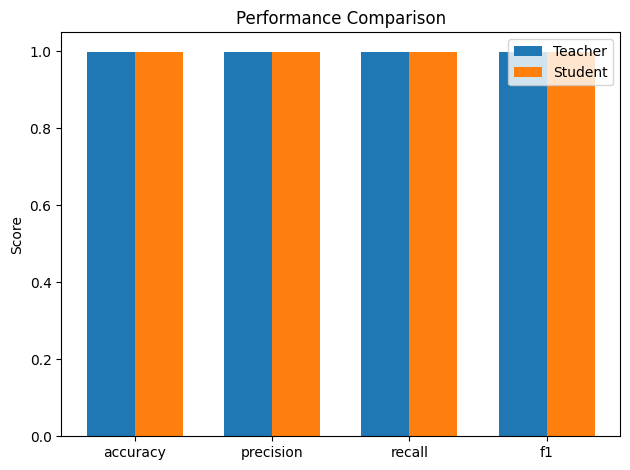

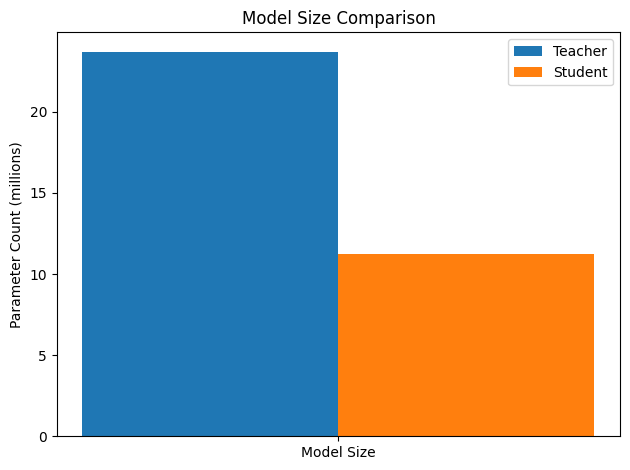

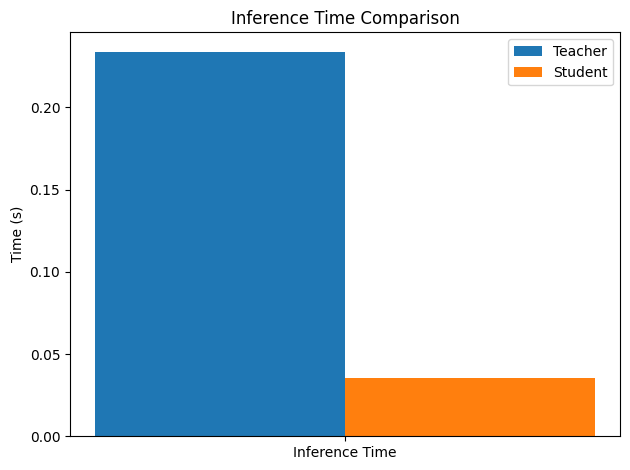

In [12]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

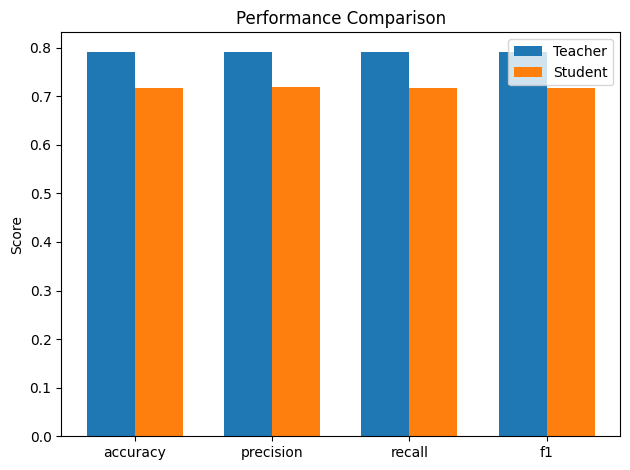

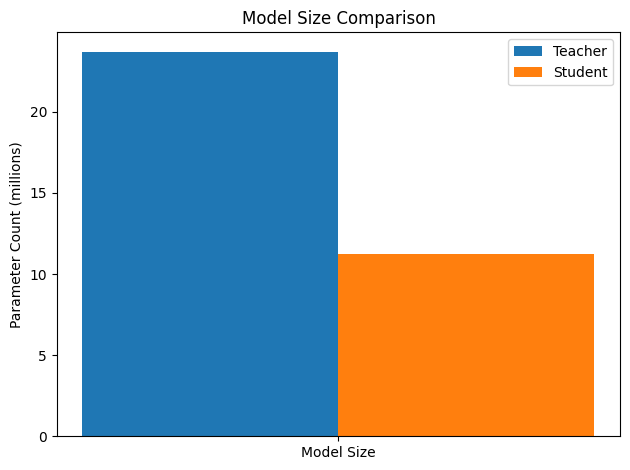

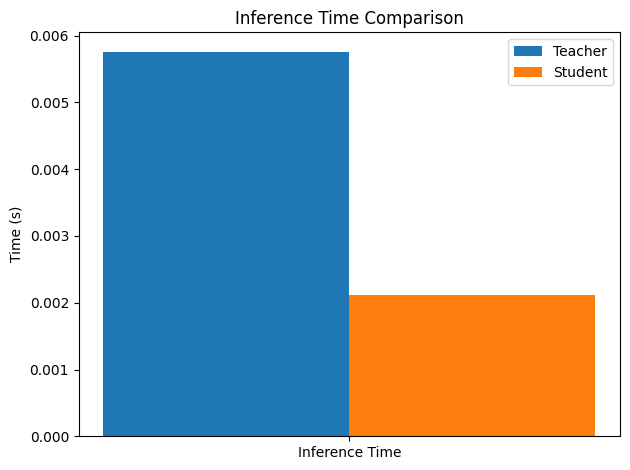

In [13]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')